# Data Science Methods for Clean Energy Research 
## _Resampling_

## Outline


### 1. Cross-validation

* 1.1 Validation set
* 1.2 Leave-One-Out cross validation
* 1.3 k-Fold cross validation

### 2. Bootstrapping

* 2.1 Finding the variance on the parameters of a regression




---







### Load libraries which will be needed in this Notebook



In [2]:
# Pandas library for the pandas dataframes
import pandas as pd    

# Import Scikit-Learn library for the regression models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

# Import numpy 
import numpy as np

import scipy.stats as stats
import scipy

# Import plotting libraries
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 20})
from IPython.display import clear_output

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2


## 1. Cross-Validation

In supervised ML methods we evaluate the validity of our estimates by using the test set. Suppose that you only have a very small test set, or no test set ... how can you estimate the test error? 

One way is to use Cross-Validation by _holding out_ a subset of the training samples and updating the set which is held out at each iteration of training.

### 1.1 Validation set 

We have seen this already ... the idea of the Validation set approach is to split our data into a training and test set a.k.a _validation_ set and to look at the MSE of the test set.

In [3]:
dset = datasets.load_diabetes()

X, y = dset.data, dset.target


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8, shuffle=True)

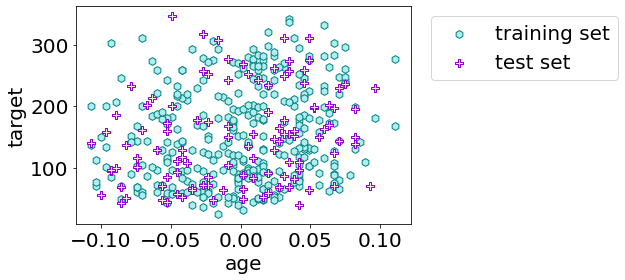

In [9]:
fig, ax = plt.subplots()
ax.scatter(X_train[:,0], y_train, s=60, marker='h', c='paleturquoise', edgecolors='teal', label='training set')
ax.scatter(X_test[:,0], y_test, s=60, marker='P', c='mistyrose', edgecolors='darkviolet',label='test set')
ax.set_ylabel("target")
ax.set_xlabel(dset.feature_names[0])
ax.legend(loc='upper right', bbox_to_anchor=(1.65, 1))
plt.show()

In [10]:
reg = linear_model.LinearRegression().fit(X_train, y_train)
y_predict = reg.predict(X_test)
r2 = r2_score(y_test, y_predict)
MSE = mean_squared_error(y_test, y_predict)

In [11]:
print("r2 score:", r2, " MSE:", MSE)

r2 score: 0.4593440496691643  MSE: 3108.0410982532094


### In class exercise - breakout room (15 min)

* Work on writing a function to repeat what we did for different test sets - you can change the seed or the size of the test set

* Run your function a few times and save the error metric ($R^2$ or MSE)

* Plot your $R^2$ or MSE for all iterations - what do you see?

In [12]:
def fit_predict(X, y, seed, split_fraction):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_fraction, random_state=seed, shuffle=True)
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    r2 = r2_score(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)    
    return r2, MSE

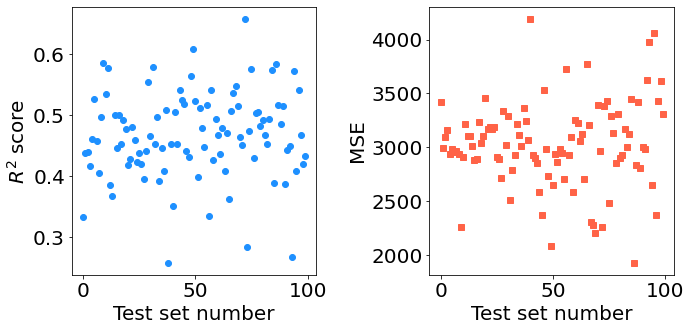

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.arange(0, N_test_samples, 1), r2_list, 'o', color='dodgerblue' )
ax[1].plot(np.arange(0, N_test_samples, 1), MSE_list, 's', color='tomato')
ax[0].set_xlabel('Test set number')
ax[0].set_ylabel('$R^2\;$score')
ax[1].set_xlabel('Test set number')
ax[1].set_ylabel('MSE')
plt.tight_layout()

Problems with this approach?

* **1)** **Depends on** the choice of points in the **test set** and in the **training set** - as you can see even by keeping the number of points constant we have a different MSE and $R^2$ score for each test set!

* **2)** Given that it has never seen the test set but has seen the training set by estimating the error only on the test set we might **overestimate the error** on the entire dataset

### 1.2 Cross-validation: _Leave-One-Out Cross-Validation_

Leave-One-Out Cross Validation LOOCV process:

* **_step 1_** Divide dataset containing $N$ points in two parts: one part contains a single data point $(x_1,y_1)$ the other contains the rest of the $N-1$ points
* **_step 2_** Train the model on the $N-1$ point set
* **_step 3_** Compute the MSE for the $(x_1,y_1)$ hold-out point
* Repeat steps 1-3 by selecting the next point $i$ in the set of $N$ points as the hold-out point


<div>
<img src="https://miro.medium.com/max/2816/1*AVVhcmOs7WCBnpNhqi-L6g.png" width='400' align=left>
</div>

We can then estimate the test MSE by averaging over the $N$ test errors:

$$\text {MSE}^{ave}_{\text{test}}\equiv\text{CV}_{(N)}=\frac{1}{N}\sum_{i=1}^N \text{MSE}_i$$



One disadvantage is that we need to make $N$ evaluations, if $N$ is large that can be time demanding.

Let's implement this for the diabetese dataset using the `LeaveOneOut()` [function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) implemented in scikit-learn 

In [15]:
loo = LeaveOneOut()
loo.get_n_splits(X)
print(loo.get_n_splits(X))
print(loo.split(X))

442
<generator object BaseCrossValidator.split at 0x7fa69938e5f0>


In [16]:
MSE_loo = []
for train_index, test_index in loo.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X train", X_train, "\nX test",  X_test, "\ny train", y_train, "\ny test", y_test)
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    MSE_loo.append(mean_squared_error(y_test, y_predict))
    
print(len(MSE_loo))

442


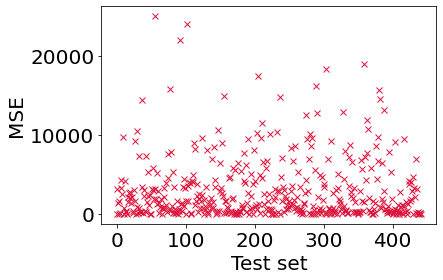

In [17]:
plt.figure()
plt.plot(MSE_loo,'x',color='crimson')
plt.xlabel('Test set')
plt.ylabel('MSE')
plt.show()

In [18]:
CV_mean_MSE = 1/len(y) * np.sum(MSE_loo)

print("Mean test MSE using LOOCV = ", CV_mean_MSE)

Mean test MSE using LOOCV =  3001.746231732946


#### Questions on LOOCV?

* Will the results change if we rerun the method?
* Which of the Validation problems are we helping to solve in LOOCV?
* Is holding out a single point each time the best option?

### 1.3 _k_-Fold Cross-Validation

_k_-Fold Cross-Validation process

* **_step 1_** Divide dataset containing $N$ points in $k$ groups or **_folds_** - each fold contains $\approx N/k$ 
* **_step 2_** Keep the first fold as a validation set and train the model on the subsequent $k-1$ folds
* **_step 3_** Compute the MSE for the first fold
* Repeat steps 1-3 by selecting the next fold $i$ in the set of $k$ folds as the validation set

Let's try it out using the `KFold()` [function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) in scikit-learn

In [19]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [20]:
MSE_kf = []
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X train", X_train, "\nX test",  X_test, "\ny train", y_train, "\ny test", y_test)
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    MSE_kf.append(mean_squared_error(y_test, y_predict))

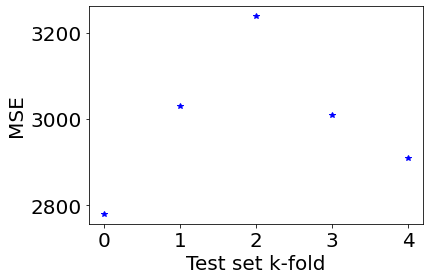

In [21]:
plt.figure()
plt.plot(MSE_kf,'*',color='blue')
plt.xlabel('Test set k-fold')
plt.ylabel('MSE')
plt.show()

In [22]:
CV_mean_5fold_MSE = 1/5. * np.sum(MSE_kf)

print("Mean test MSE using 5-fold CV = ", CV_mean_5fold_MSE)

Mean test MSE using 5-fold CV =  2993.072943299887


### Advantages of k-fold Cross-Validation

* **Cheaper than LOOCV** as we only need $k$ iterations instead of $N$ (LOOCV is basically k-fold CV with $k=N$)
* Variability in MSE is smaller than what we had with the Validation set approach (some of the training data is seen a few times)
* Often gives **better estimates of the test error** rate than LOOCV due to the bias-variance tradeoff.
    * LOOCV has lower bias than k-fold CV when $k< N$ (sees more of the population)
    * LOOCV has higher variance than k-fold CV when $k<N$ ( less overlap between training sets)
    * From the bias-variance tradeoff, values of $k$ which lead to models which does not suffer from high bias of variance are $k=5$ and $k=10$

Another example use of cross validation is to train deep neural networks DNN

<div>
    
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width='400' align=left>
</div>


## 2. Bootstrapping

Bootstrapping refers to tests or metrics that uses **random sampling with replacement**. It is part of the class of **resampling** methods. Bootstrapping assigns measures of accuracy (bias, variance, confidence intervals, prediction error, etc.) to sample estimates.

Bootstrapping is very useful to estimate the accuracy of an estimator .. for instance the variance on linear regression coefficients

**Algorithm**

* Randomly draw $n$ data points, with replacement, from your training data set (size = $n$).
* Train your model and calculate coefficients/parameters
* Repeat sampling many times (usually 1000), and calculate the variance of your coefficients


### 2.1 Exercise: Bootstrapping for the Cheetah dataset (10 min)

Let's use this for our cheetah dataset! We want to estimate the error on our estimate of each coefficient when using multiple linear regression.

We will use the scikit-learn `resample()` function - for more info see [here](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html)

To solve this problem:
* Use the `resample()` function to extract 20 samples from X and y (we loaded these from the cheetah dataset a few cells back) with `replace=True` - Note: each sample should be different! 
* Fit a multiple linear regression to each model and store the coefficients and intercept
* Evaluate the mean and standard deviation of the coefficients

In [23]:
cheetah_df=pd.read_csv('datasets/running_cheetah.csv',index_col=0)
cheetah_df.describe()

,time [hr],position [miles],speed [miles/hr],energy [lb*(miles/hr)**2]
count,200.000000,200.000000,200.000000,200.000000
mean,54.395276,3616.685661,65.542620,306545.048289
std,30.175465,2007.239134,9.154178,83675.796781
min,0.487785,-25.255573,50.197096,176382.392260
25%,27.720194,1830.304592,57.673334,232834.968468
50%,55.237215,3649.079273,65.958699,304539.576823
75%,82.162558,5239.967764,73.646036,379661.698365
max,99.949809,7418.152936,79.924249,447151.990463


In [24]:
X = cheetah_df[['time [hr]','speed [miles/hr]']].values.reshape(-1, 2)
y = cheetah_df['position [miles]'].values.reshape(-1, 1)
print(type(cheetah_df['position [miles]'].values.reshape(-1, 1)), cheetah_df['position [miles]'].values.reshape(-1, 1).shape)

<class 'numpy.ndarray'> (200, 1)


In [64]:
N_samples = 400
coeffs = []
intercepts = []


for i in range(N_samples):
    # Note the random state changes everytime! Here I am keeping track of it
    boot_X, boot_y = resample(X, y, replace=True, n_samples=len(y), random_state=i)
    
    reg = linear_model.LinearRegression().fit(boot_X, boot_y)
    coeffs.append(reg.coef_)
    intercepts.append(reg.intercept_)

#print(coeffs)
#print("intercepts", intercepts)

In [65]:
N_coeffs = X.shape[1]

coeffs_new = np.array(coeffs).reshape(-1, N_coeffs)

for j in range(N_coeffs):

    print("Coeff "+str(j)+" - Mean = ", round(np.mean(coeffs_new[:,j]),2), "+- Std. Dev ", round(np.std(coeffs_new[:,j]),2))

print("Intercept - Mean = ", round(np.mean(intercepts),2), "+- Std. Dev:", round(np.std(intercepts),2))


Coeff 0 - Mean =  64.14 +- Std. Dev  0.88
Coeff 1 - Mean =  55.84 +- Std. Dev  2.79
Intercept - Mean =  -3533.14 +- Std. Dev: 192.03


Now see how things change as you change the number of samples you bootstrap ... or as you change the number of points per sample

In [66]:
N_samples = 100
coeffs = []
intercepts = []


for i in range(N_samples):

    boot_X, boot_y = resample(X, y, replace=True, n_samples=len(y), random_state=i)
    reg = linear_model.LinearRegression().fit(boot_X, boot_y)
    coeffs.append(reg.coef_)
    intercepts.append(reg.intercept_)


In [67]:
N_coeffs = X.shape[1]

coeffs_new = np.array(coeffs).reshape(-1, N_coeffs)

for j in range(N_coeffs):

    print("Coeff "+str(j)+" - Mean = ", round(np.mean(coeffs_new[:,j]),2), "+- Std. Dev ", round(np.std(coeffs_new[:,j]),2))

print("Intercept - Mean = ", round(np.mean(intercepts),2), "+- Std. Dev:", round(np.std(intercepts),2))

Coeff 0 - Mean =  64.09 +- Std. Dev  0.8
Coeff 1 - Mean =  56.43 +- Std. Dev  2.93
Intercept - Mean =  -3568.62 +- Std. Dev: 197.77


In [68]:
N_samples = 50
coeffs = []
intercepts = []


for i in range(N_samples):

    boot_X, boot_y = resample(X, y, replace=True, n_samples=len(y)*100, random_state=i)
    reg = linear_model.LinearRegression().fit(boot_X, boot_y)
    coeffs.append(reg.coef_)
    intercepts.append(reg.intercept_)


In [69]:
N_coeffs = X.shape[1]

coeffs_new = np.array(coeffs).reshape(-1, N_coeffs)

for j in range(N_coeffs):

    print("Coeff "+str(j)+" - Mean = ", round(np.mean(coeffs_new[:,j]),2), "+- Std. Dev ", round(np.std(coeffs_new[:,j]),2))

print("Intercept - Mean = ", round(np.mean(intercepts),2), "+- Std. Dev:", round(np.std(intercepts),2))

Coeff 0 - Mean =  64.15 +- Std. Dev  0.08
Coeff 1 - Mean =  55.79 +- Std. Dev  0.3
Intercept - Mean =  -3529.37 +- Std. Dev: 21.6
